In [38]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import json
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [39]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [40]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [41]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [42]:
with open('rateAvg_dataNEW.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('rateAvg_badNEW.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)    

x_good = []
x_bad = []

titles_good = []
titles_bad = []

for key in data.keys():
    if key != 'HLT':
        x_good.append([data[key]['samples']])
        titles_good.append(key)
for key in bad_data.keys():
    if key != 'HLT':
        x_bad.append([bad_data[key]['samples']])
        titles_bad.append(key)

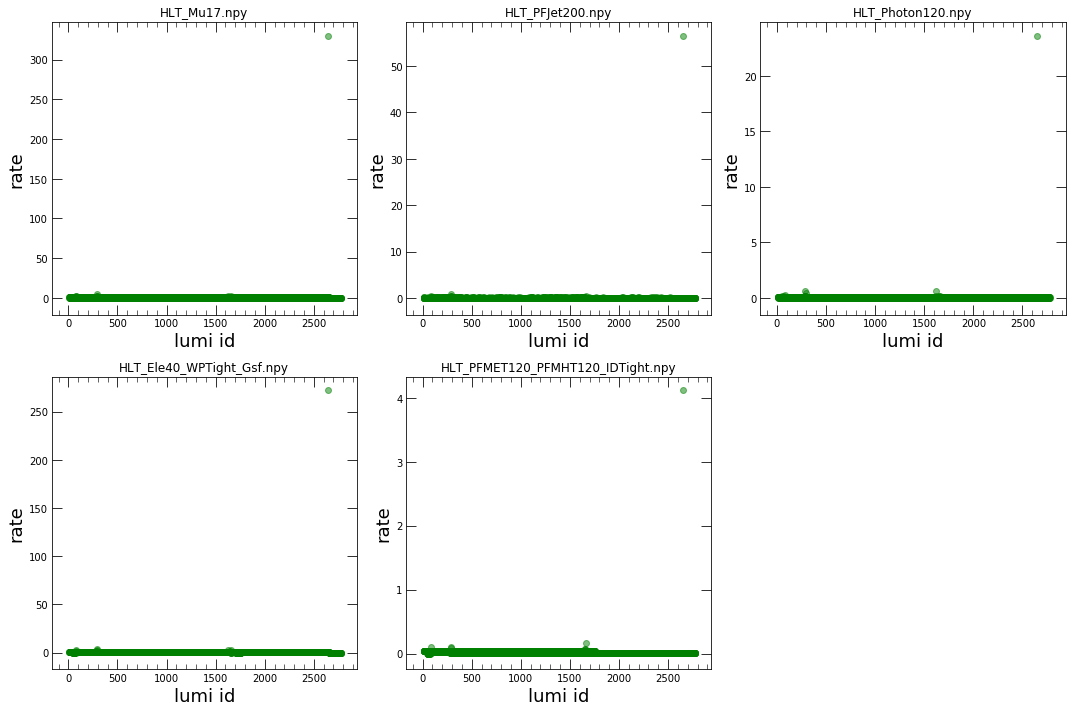

In [43]:
plots = x_good + x_bad
titles = titles_good + titles_bad

stuff = []
lumi = []
inst = []
pileup = []

for i in range(3):
    stuff.append([])
    lumi.append([])
    inst.append([])
    pileup.append([])

for h in range(3):
    if h < len(x_good):
        lumi[h] = data[titles[h]]['lumiid']
        inst[h] = data[titles[h]]['instlumi']
        pileup[h] = data[titles[h]]['pileup']
        stuff[h] = data[titles[h]]['rates']
    else:
        lumi[h] = bad_data[titles[h]]['lumiid']
        inst[h] = bad_data[titles[h]]['instlumi']
        pileup[h] = bad_data[titles[h]]['pileup']
        stuff[h] = bad_data[titles[h]]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(3):
        if k < len(x_good):
            plt.scatter(lumi[k],stuff[k][i],c='g',label=titles[k],alpha=.5)
        else:
            plt.scatter(lumi[k],stuff[k][i],c='r',label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    #plt.legend()

plt.tight_layout()
'''
plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
'''
plt.show()

## Simple Autoencoder

In [44]:
model_name = "normedRateAvgNeat"

In [45]:
# Define the architecture

_input = Input(shape=(6,), name="input")

middle = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle")(_input)

norm = BatchNormalization()(middle)

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(norm)

normhidden = BatchNormalization()(hidden)

middle2 = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle2")(normhidden)

normmiddle = BatchNormalization()(middle2)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(normmiddle)

normout = BatchNormalization()(output)

model = Model(_input, normout)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
middle (Dense)               (None, 5)                 35        
_________________________________________________________________
batch_normalization_13 (Batc (None, 5)                 20        
_________________________________________________________________
encoded (Dense)              (None, 3)                 18        
_________________________________________________________________
batch_normalization_14 (Batc (None, 3)                 12        
_________________________________________________________________
middle2 (Dense)              (None, 5)                 20        
_________________________________________________________________
batch_normalization_15 (Batc (None, 5)                 20        
__________

[[0.0, 10.358152088941194, 1.3391609904139101, 0.0, 0.28669884003329194, 6.777190779108495], [0.0, 5.164240806888762, 1.3353251187977777, 0.0, 0.2453014455482703, 6.097493302004419], [0.0, 4.134609051943398, 0.712727868317407, 0.0, 0.18113525881784448, 4.16020419550587], [0.0, 10.829853217309028, 1.4001452257412788, 0.0, 0.5318231436562123, 13.324586355617988], [0.0, 1.997937744545931, 0.5166096032220487, 0.0, 0.6831044152675431, 11.595649316257855], [0.0, 2.9336281652583143, 1.8963811954657754, 0.0, 0.2242130171699203, 6.016033312389475], [0.0, 0.0, 0.0, 0.0, 0.0, 6.129733835319021], [0.0, 0.0, 0.0, 0.0, 0.0, 5.984695612800726], [19.045378902254754, 7.458330306639517, 0.4821277942177551, 0.595778555428915, 0.7271872459415976, 23.206950099234696], [20.955925115116088, 4.074763492692189, 0.7294274051011741, 0.6009156495360116, 0.7742050387837504, 22.773001960303258], [22.030782309680824, 6.555719067821754, 0.40360037199600285, 0.6256920570532165, 0.7367379167678285, 22.957057940003438],

Train on 1541 samples, validate on 2644 samples
Epoch 1/1000
 - 8s - loss: 199.6045 - val_loss: 10802.9340
Epoch 2/1000
 - 0s - loss: 199.5569 - val_loss: 11289.3548
Epoch 3/1000
 - 0s - loss: 199.2539 - val_loss: 11395.1079
Epoch 4/1000
 - 0s - loss: 199.1008 - val_loss: 11392.1274
Epoch 5/1000
 - 0s - loss: 199.0594 - val_loss: 11287.3933
Epoch 6/1000
 - 0s - loss: 198.9934 - val_loss: 11175.3472
Epoch 7/1000
 - 0s - loss: 198.7735 - val_loss: 11270.9536
Epoch 8/1000
 - 0s - loss: 198.7416 - val_loss: 11184.5355
Epoch 9/1000
 - 0s - loss: 198.4080 - val_loss: 11248.5995
Epoch 10/1000
 - 0s - loss: 198.2697 - val_loss: 11288.1195
Epoch 11/1000
 - 0s - loss: 198.1694 - val_loss: 11301.5998
Epoch 12/1000
 - 0s - loss: 198.1370 - val_loss: 11290.9271
Epoch 13/1000
 - 0s - loss: 198.2412 - val_loss: 11380.0839
Epoch 14/1000
 - 0s - loss: 197.7105 - val_loss: 11430.2688
Epoch 15/1000
 - 0s - loss: 197.7261 - val_loss: 11435.2957
Epoch 16/1000
 - 0s - loss: 197.5356 - val_loss: 11466.2791
E

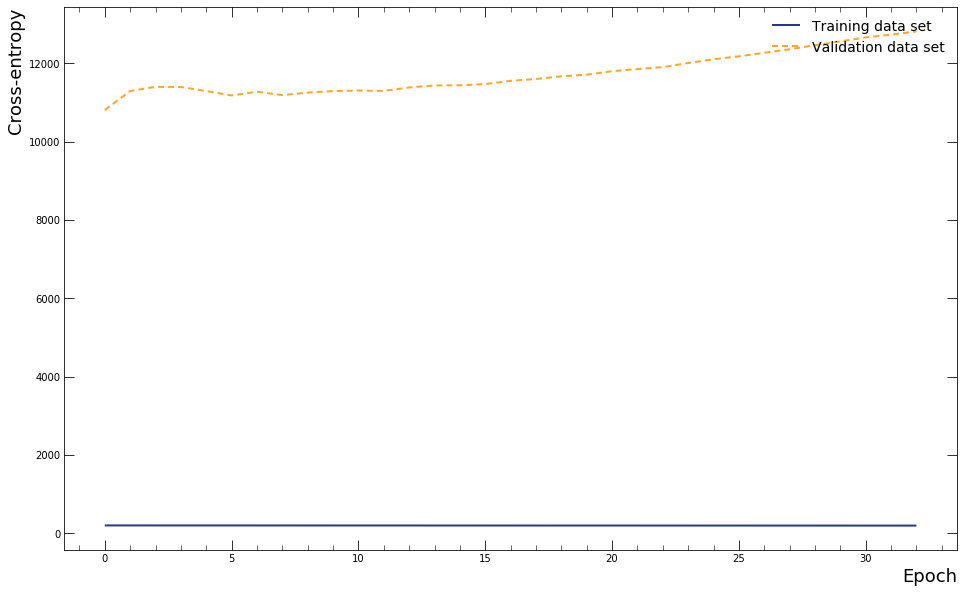

In [46]:
# Train neural networks
x_train = x_good[0]
x_val = x_good[1]

print(x_train[0])

history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

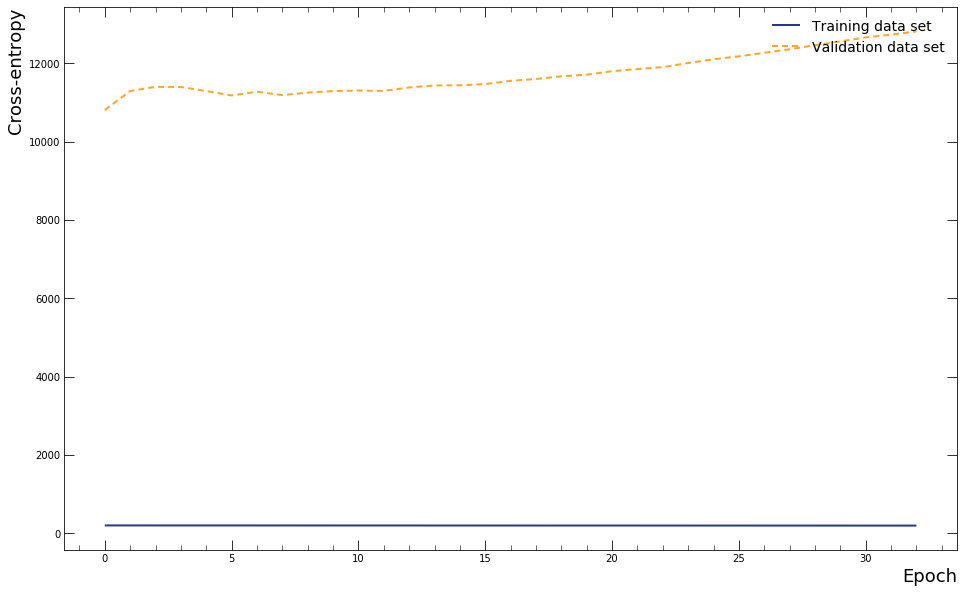

In [47]:
plot_loss(history)

## Training Set

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [12]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

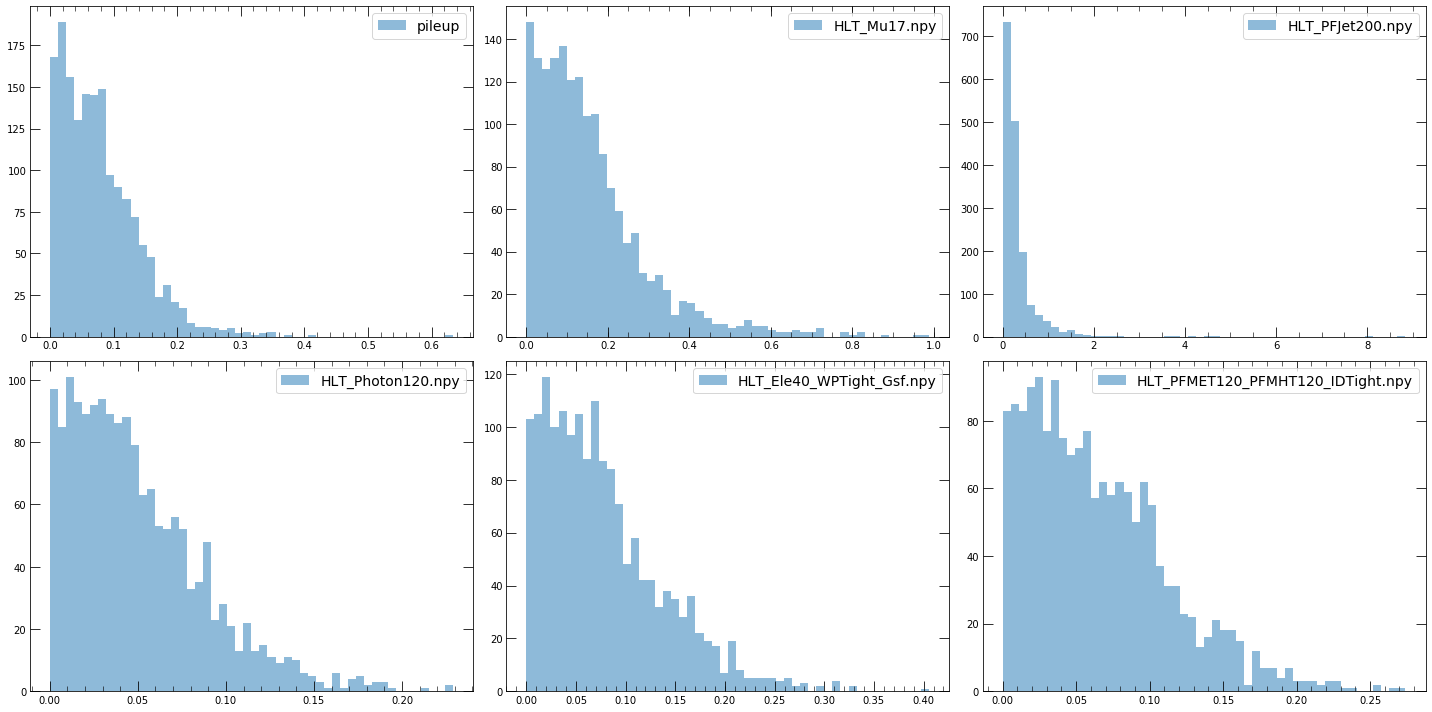

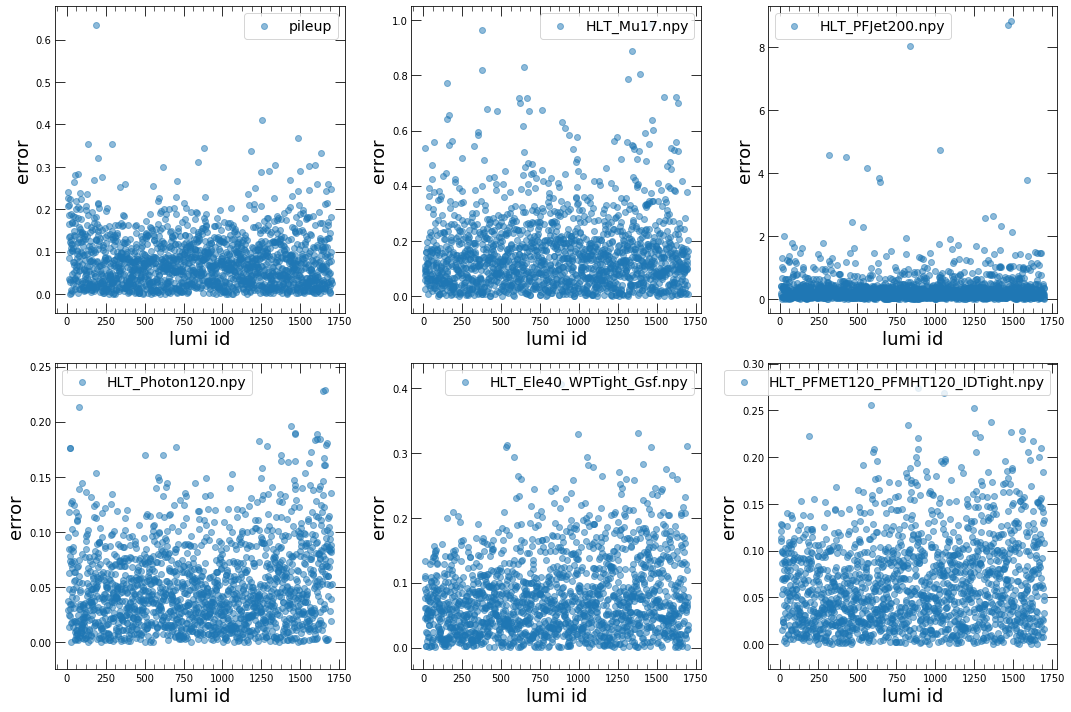

In [13]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

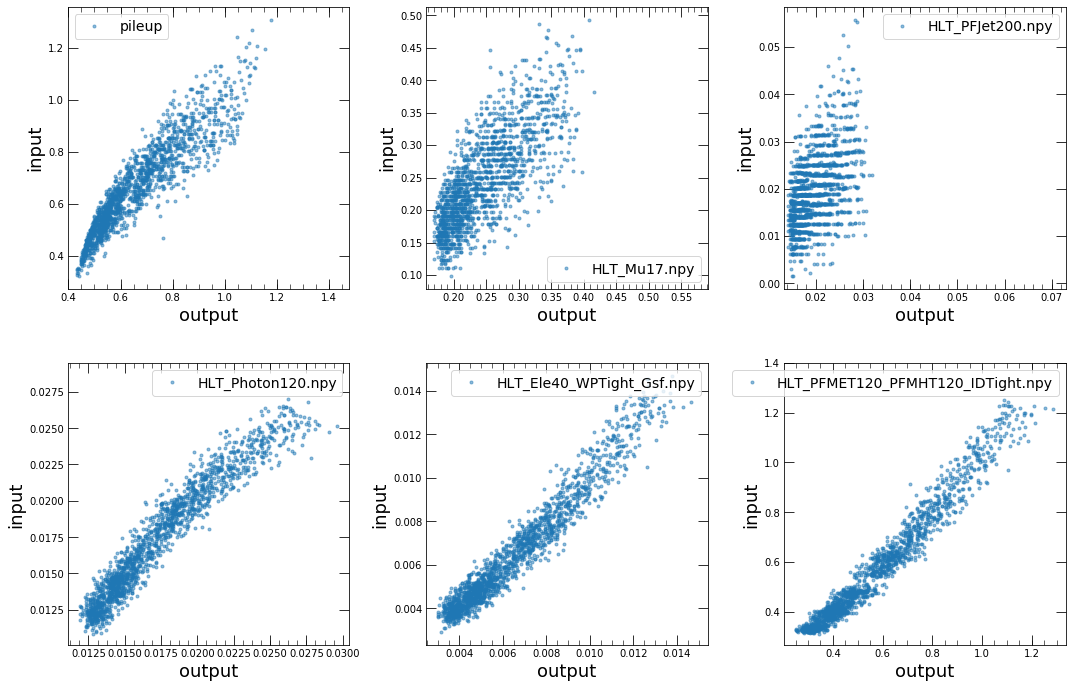

In [14]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Squared Difference

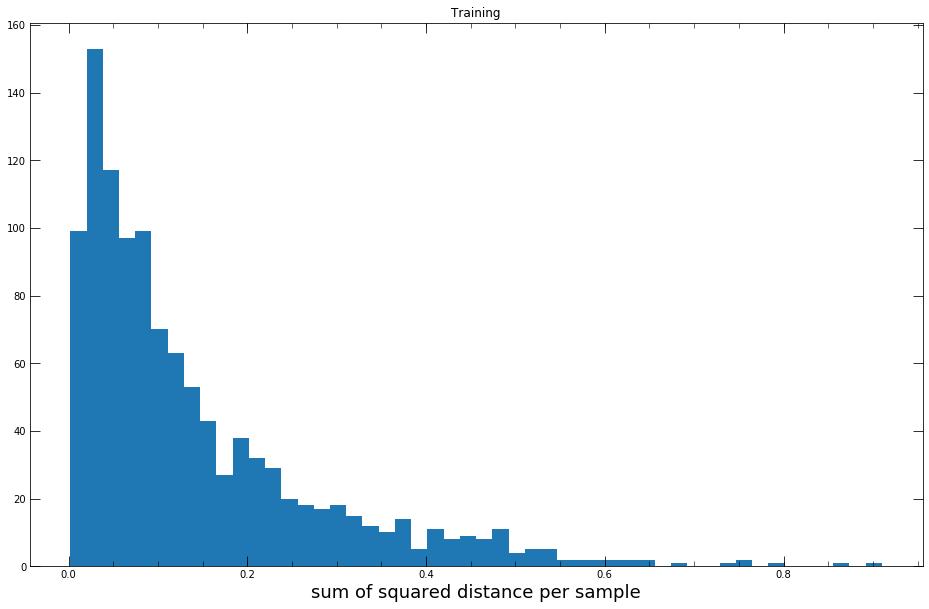

In [47]:
error_test = []
for r in range(len(reconstructed)):
    temp = 0
    for s in range(len(reconstructed[r])):
        temp+=(reconstructed[r][s]-x_train[r][s])**2
    error_test.append(temp)

plt.figure()
plt.hist(error_test,bins=50)
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.show()

## Test Data

In [52]:
# Generate predictions

x_test = np.array(data[str(runs[2])]['samples'])

model = load_model("%s.h5" % (model_name))

reconstructed = model.predict(np.array(x_test))

error = abs(x_test-reconstructed)/x_test

In [53]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test[i][j])

[  10.   11.   12. ... 1148. 1149. 1150.]
1129 1129
1129 1129
1129 1129
1129 1129
1129 1129
1129 1129


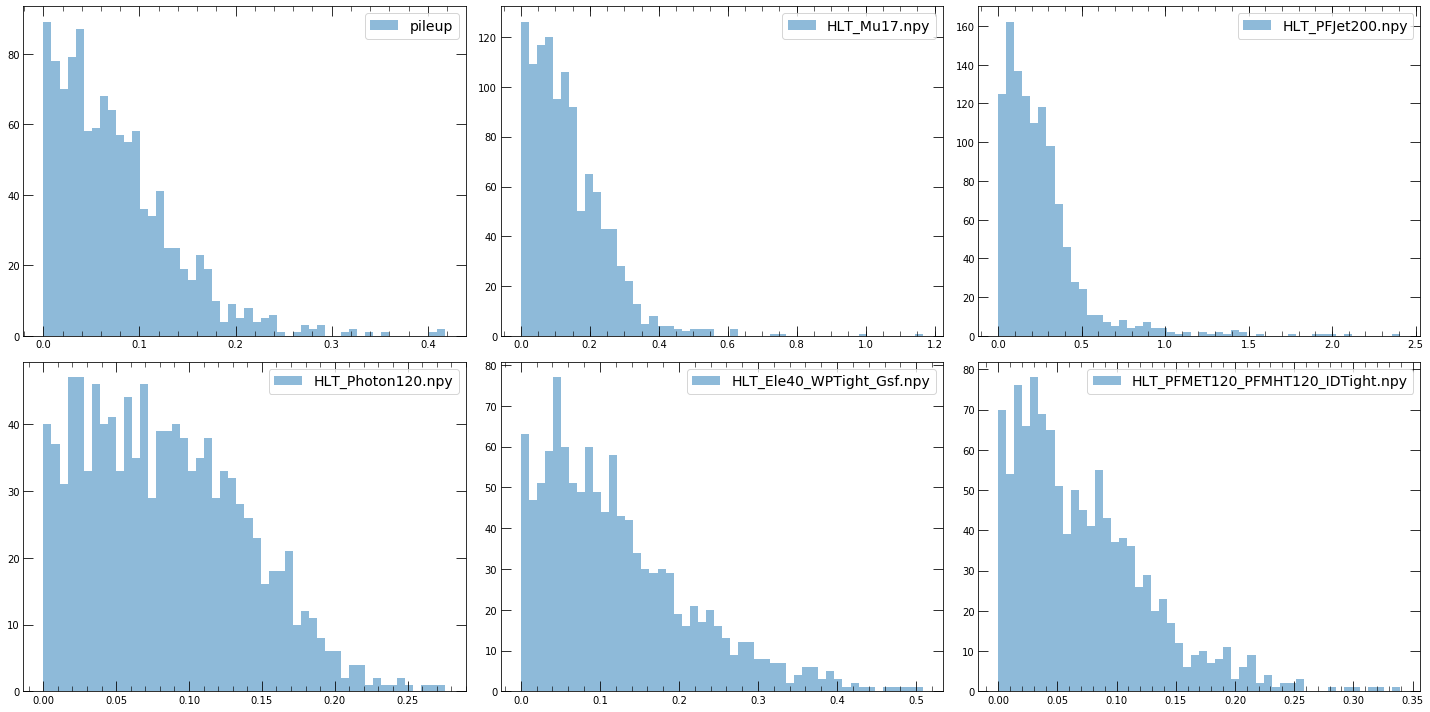

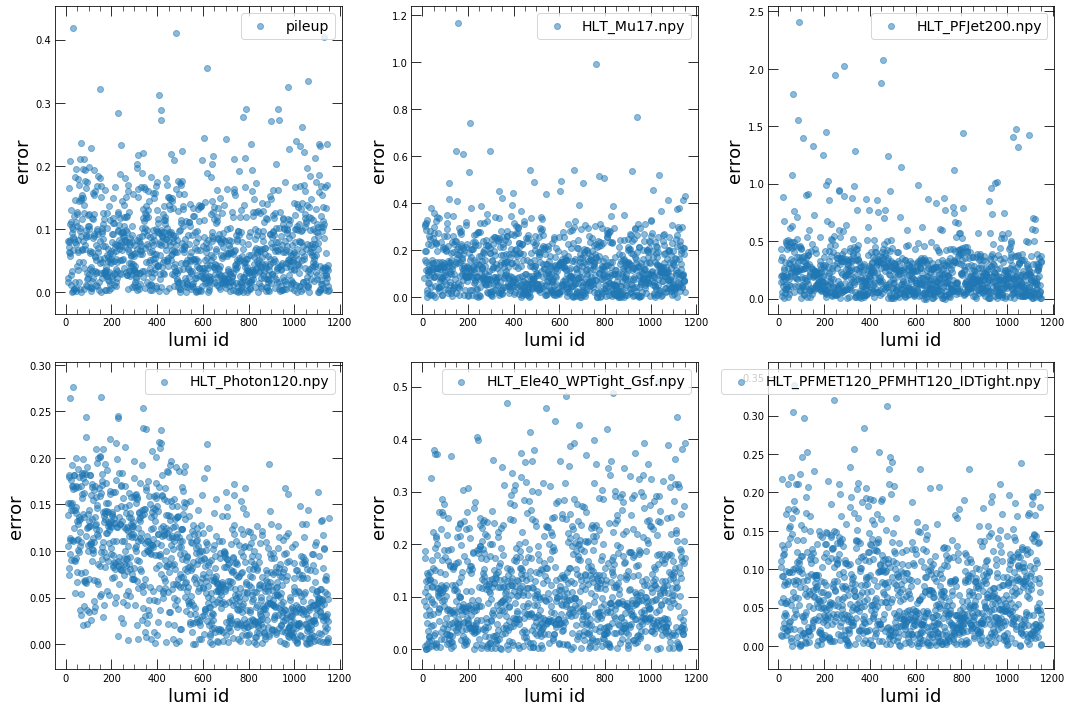

In [54]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid']
print(lumi)
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    print(len(error_reformat[i]),len(lumi))
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

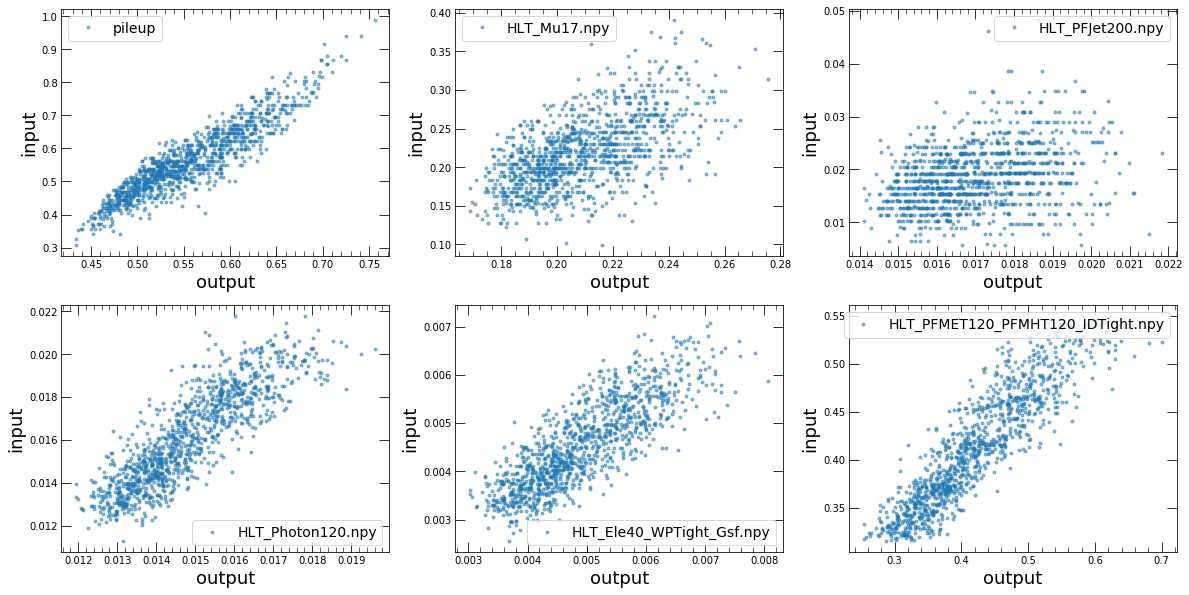

In [55]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Squared Difference

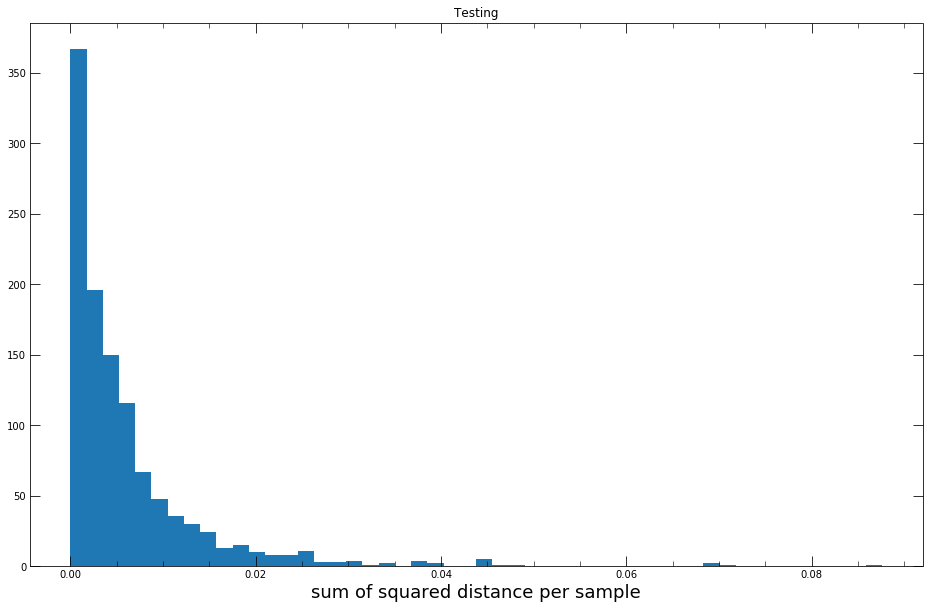

In [58]:
error_test = []
for r in range(len(reconstructed)):
    temp = 0
    for s in range(len(reconstructed[r])):
        temp+=(reconstructed[r][s]-x_test[r][s])**2
    error_test.append(temp)

plt.figure()
plt.hist(error_test,bins=50)
plt.xlabel('sum of squared distance per sample')
plt.title('Testing')
plt.show()

## Fake Bad Data

In [69]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [70]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [71]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

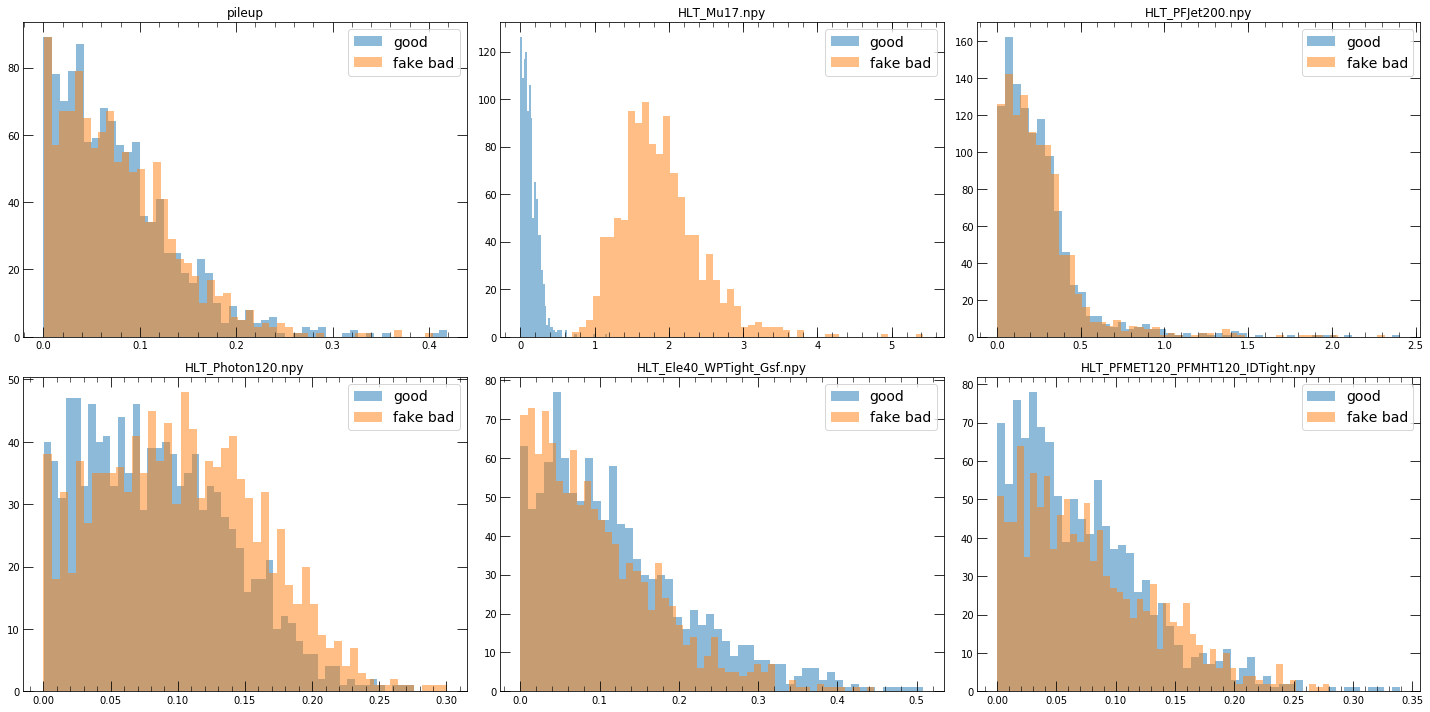

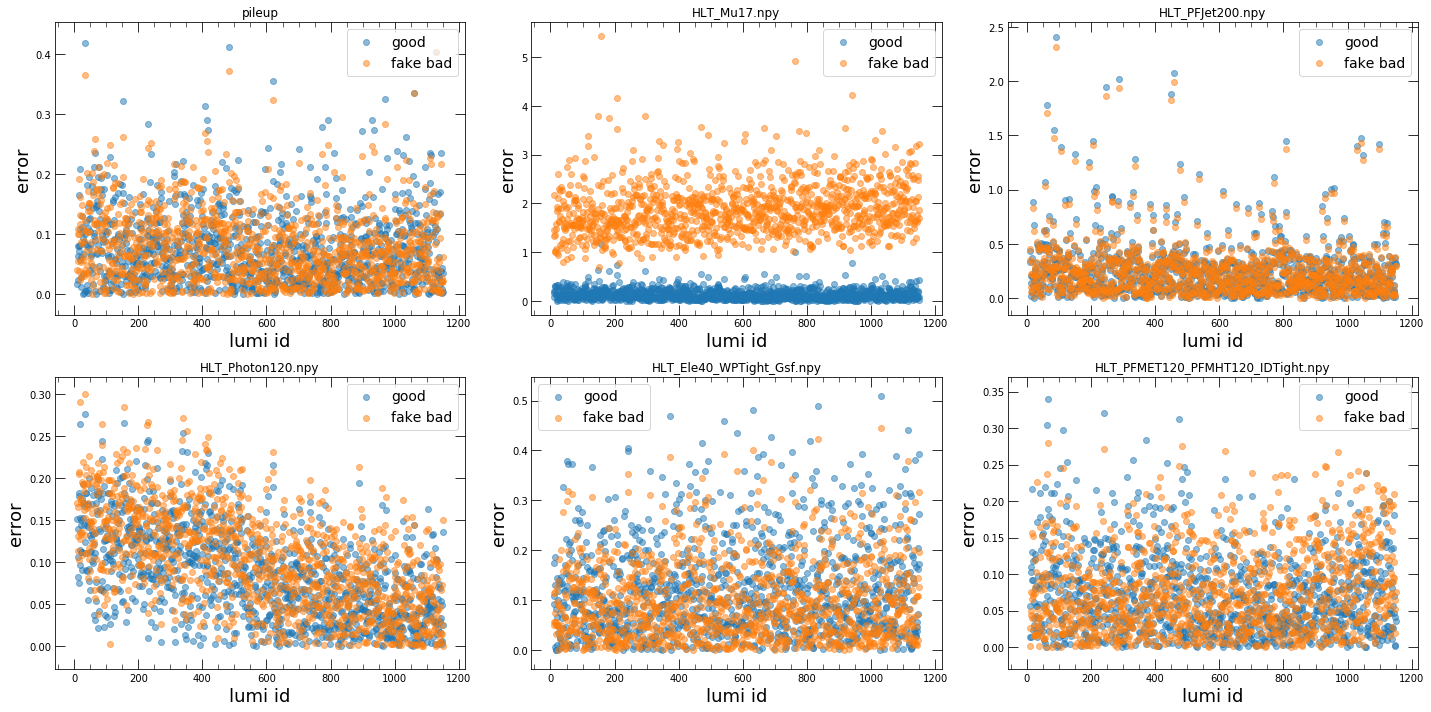

In [72]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

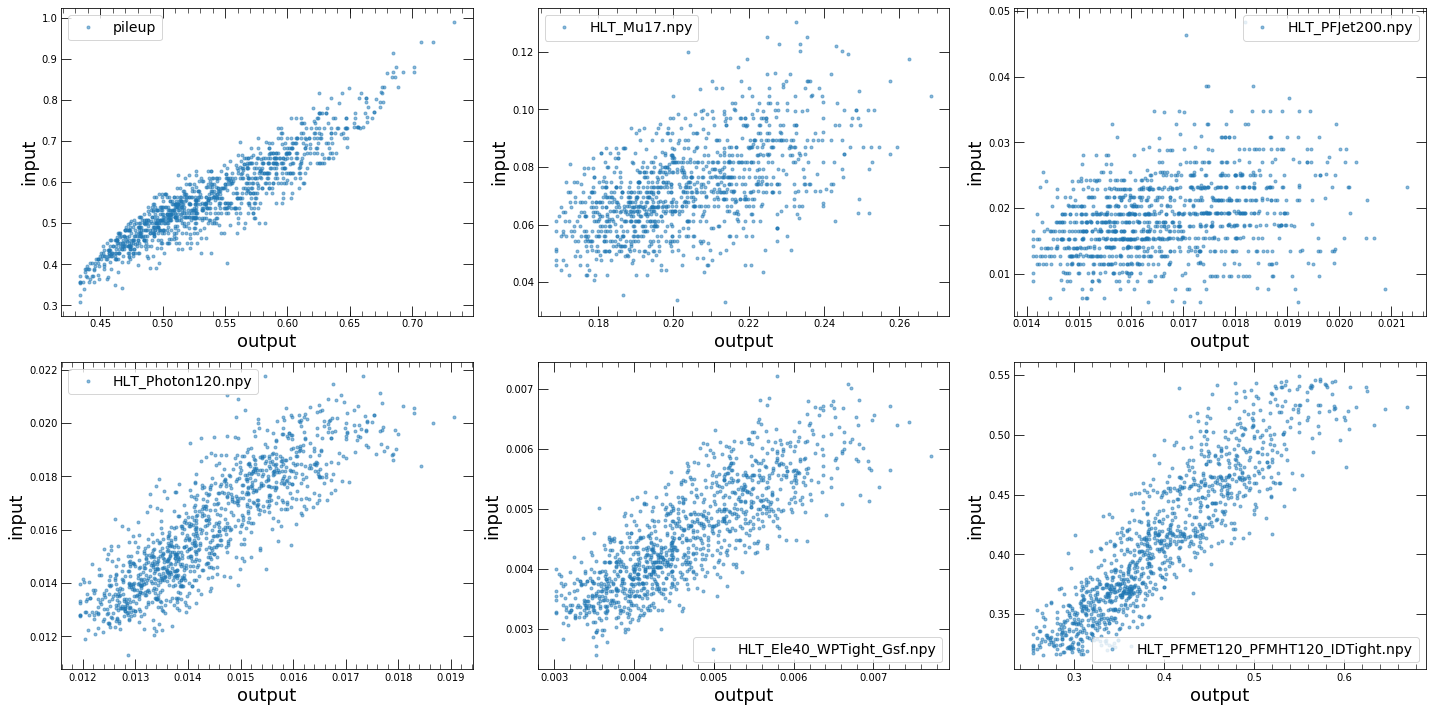

In [73]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

## Squared Difference

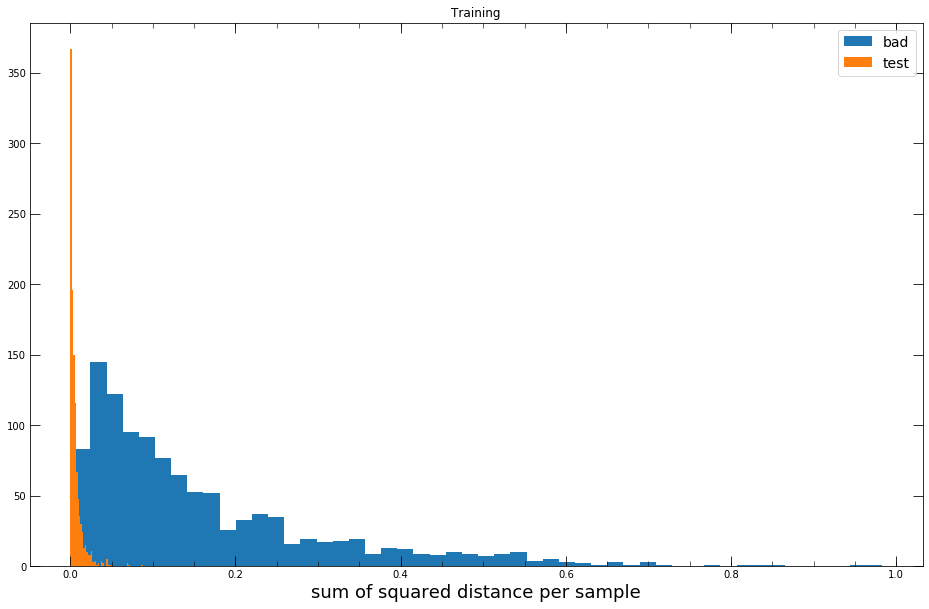

In [74]:
error_bad1 = []
for r in range(len(reconstructed_bad)):
    temp = 0
    for s in range(len(reconstructed_bad[r])):
        temp+=(reconstructed_bad[r][s]-x_train[r][s])**2
    error_bad1.append(temp)

plt.figure()
plt.hist(error_bad1,bins=50,label='bad')
plt.hist(error_test,bins=50,label='test')
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.legend()
plt.show()

## Fake Bad Data - ALL

In [75]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [76]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [77]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


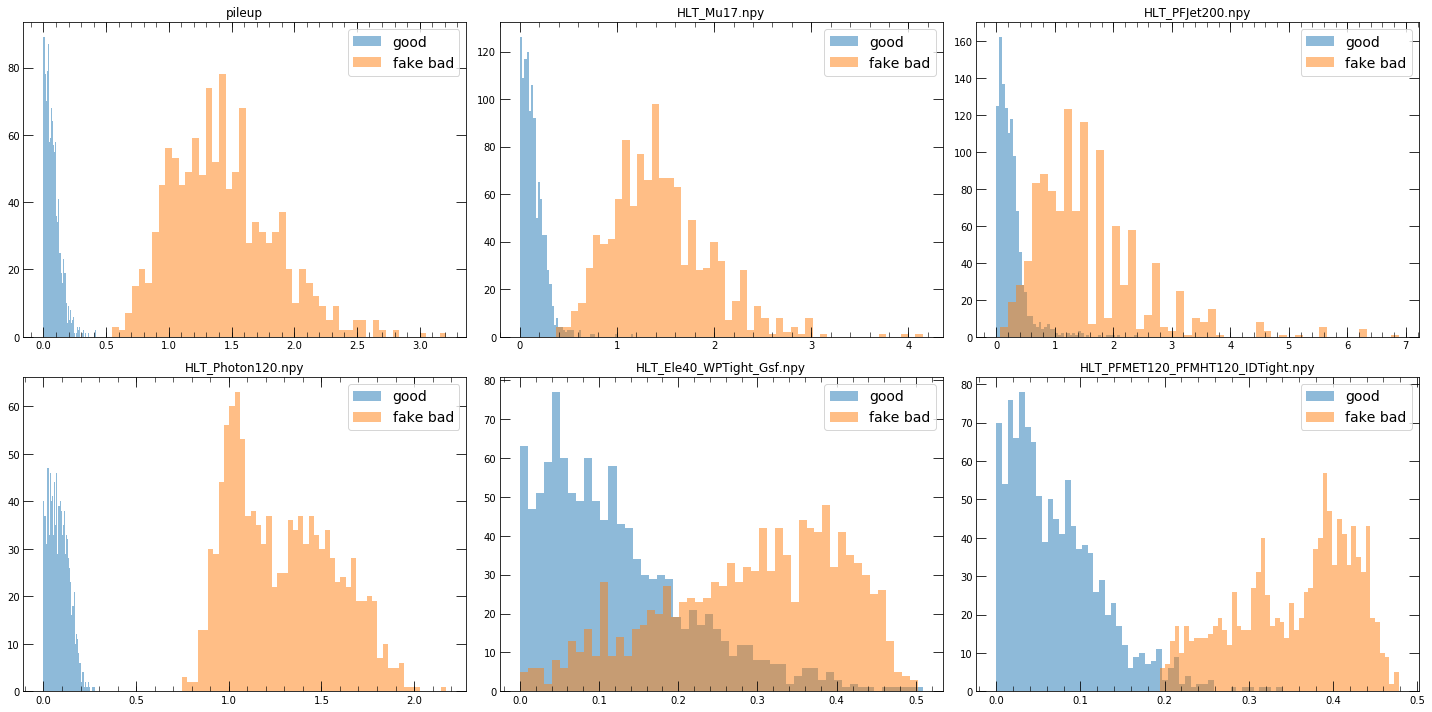

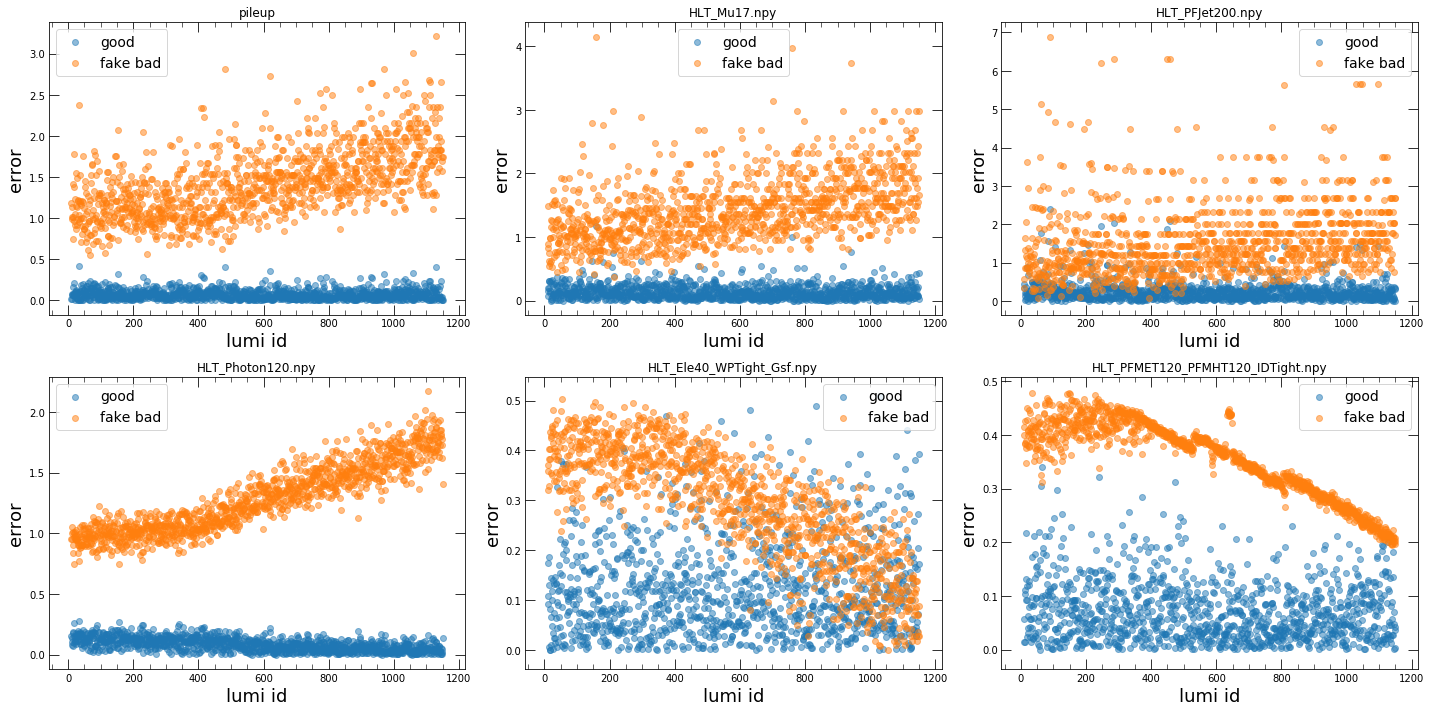

In [78]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

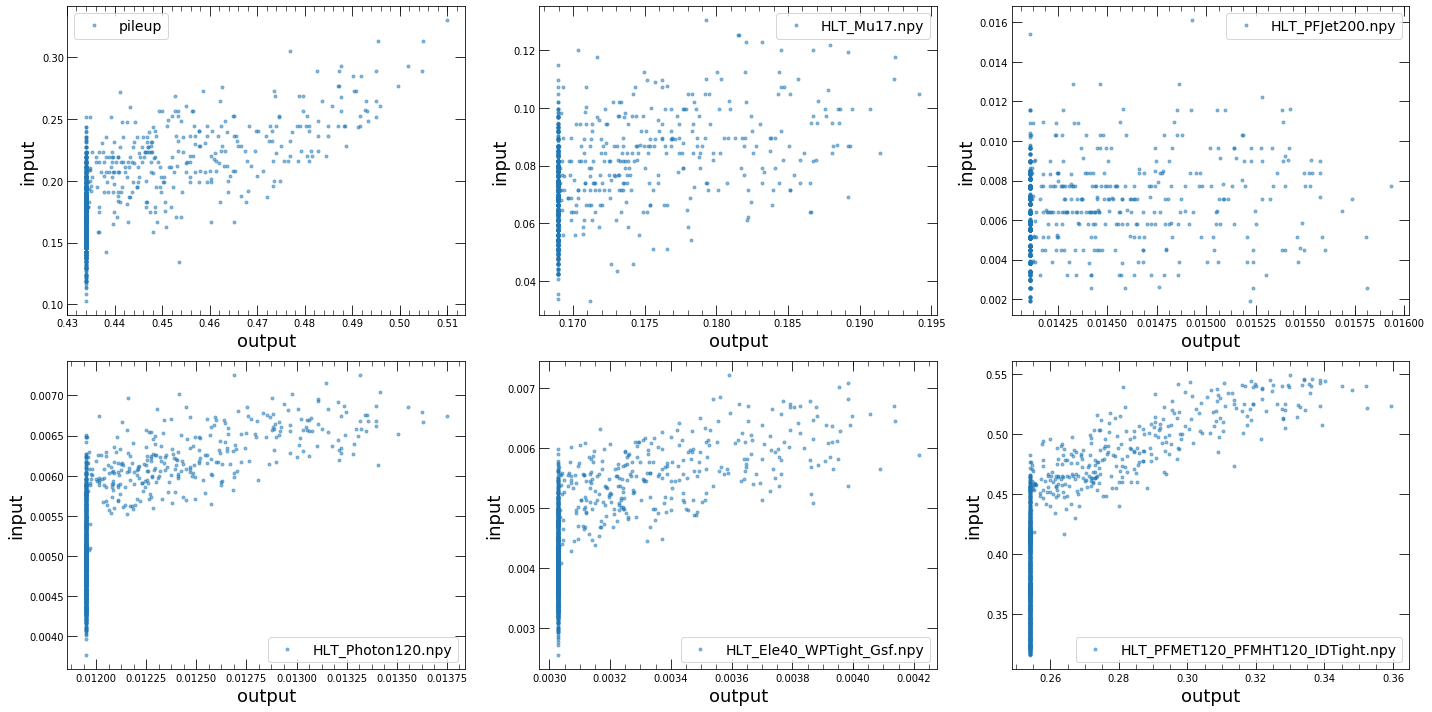

In [79]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

## Squared Difference

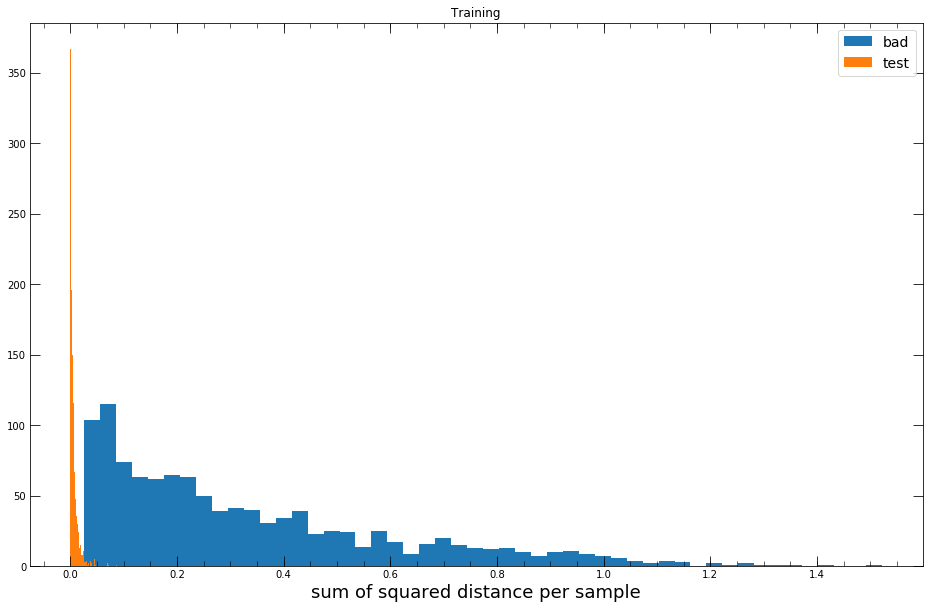

In [80]:
error_bad2 = []
for r in range(len(reconstructed_bad)):
    temp = 0
    for s in range(len(reconstructed_bad[r])):
        temp+=(reconstructed_bad[r][s]-x_train[r][s])**2
    error_bad2.append(temp)

plt.figure()
plt.hist(error_bad2,bins=50,label='bad')
plt.hist(error_test,bins=50,label='test')
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.legend()
plt.show()

## Real Bad Data

In [81]:
bad_runs = [301480]

with open('normedRateAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [82]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [83]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

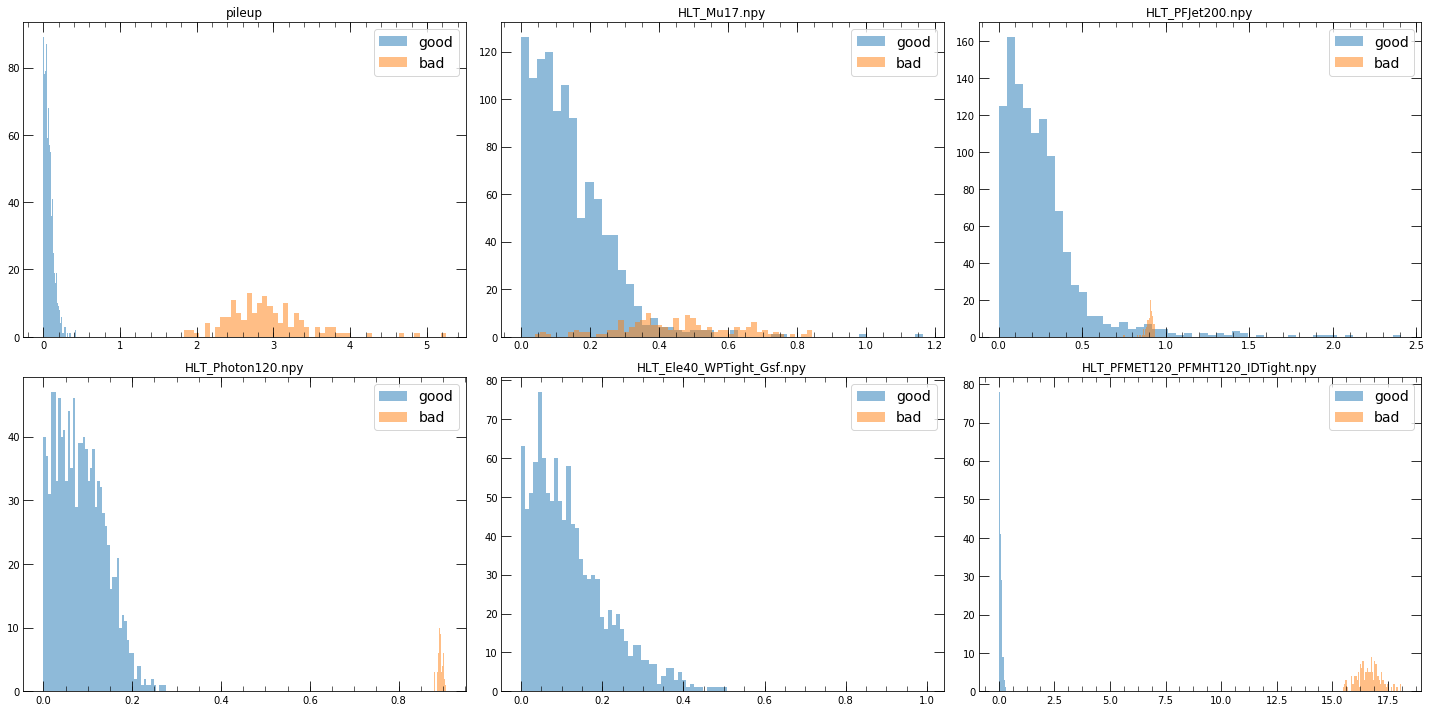

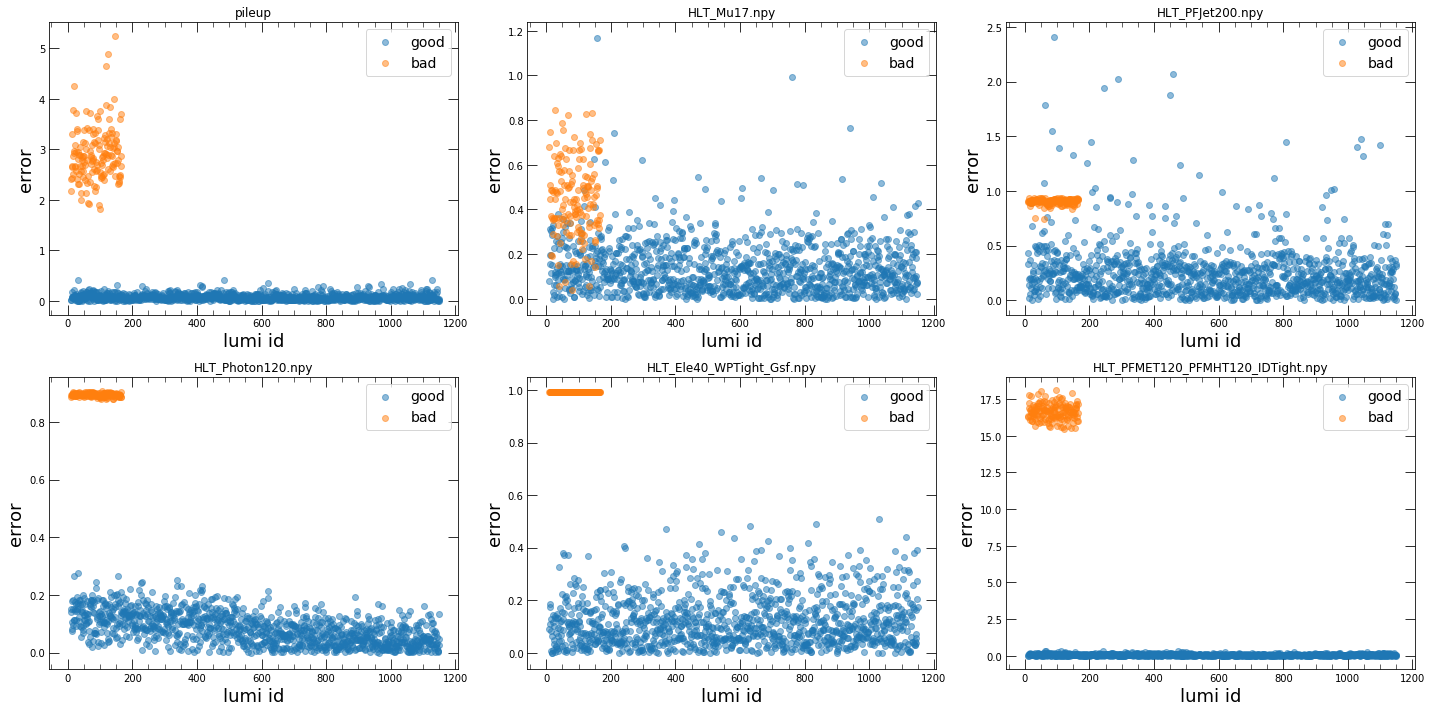

In [84]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

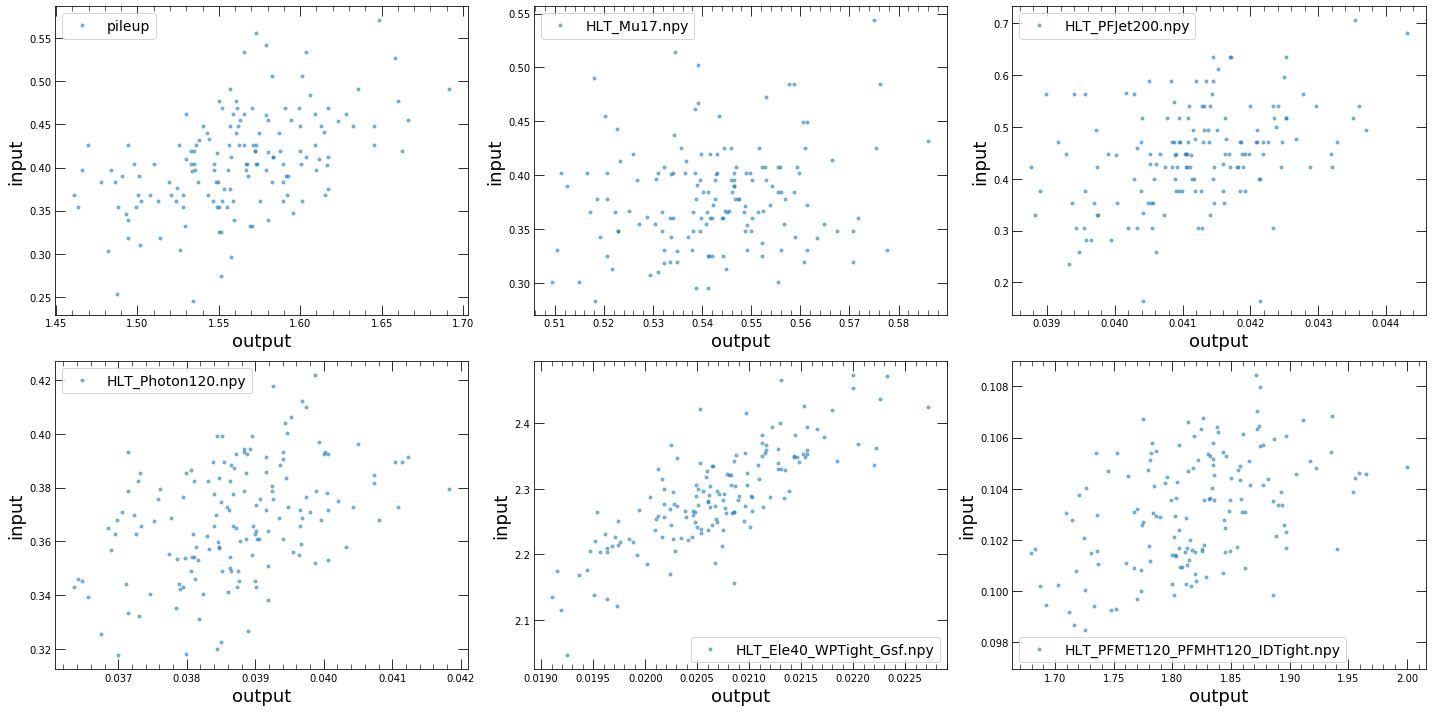

In [85]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Squared Difference

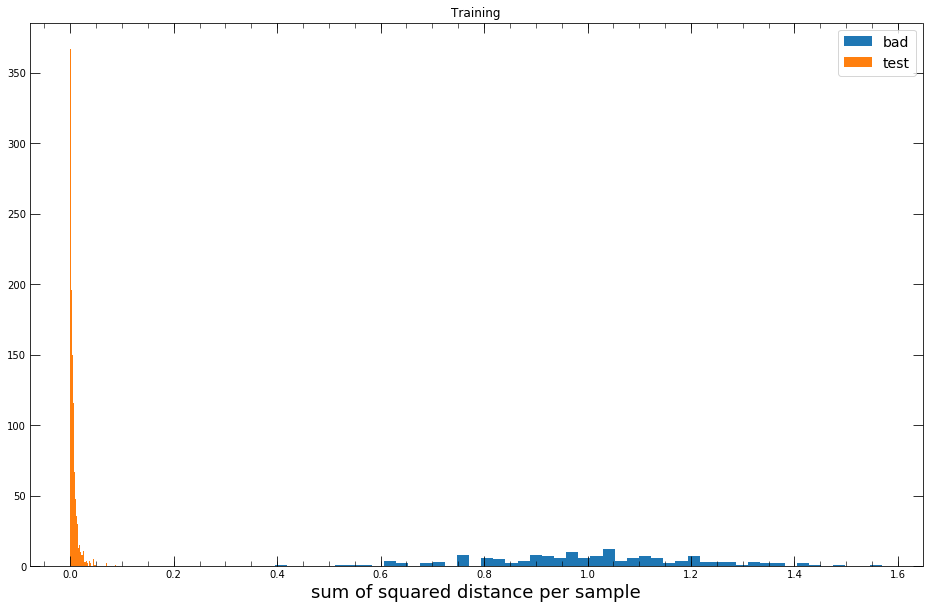

In [86]:
error_bad_real1 = []
for r in range(len(reconstructed_bad)):
    temp = 0
    for s in range(len(reconstructed_bad[r])):
        temp+=(reconstructed_bad[r][s]-x_train[r][s])**2
    error_bad_real1.append(temp)

plt.figure()
plt.hist(error_bad_real1,bins=50,label='bad')
plt.hist(error_test,bins=50,label='test')
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.legend()
plt.show()

## Real Bad Data

In [87]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [88]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [89]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

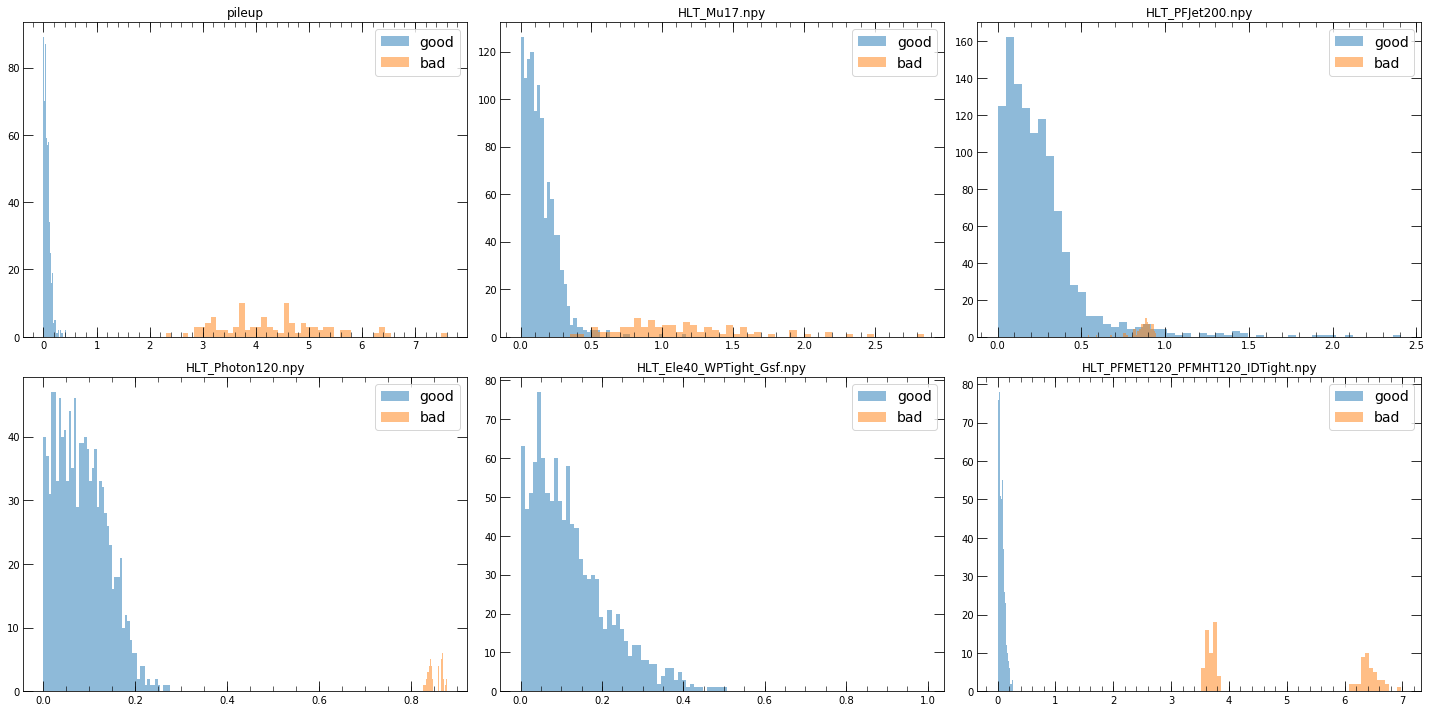

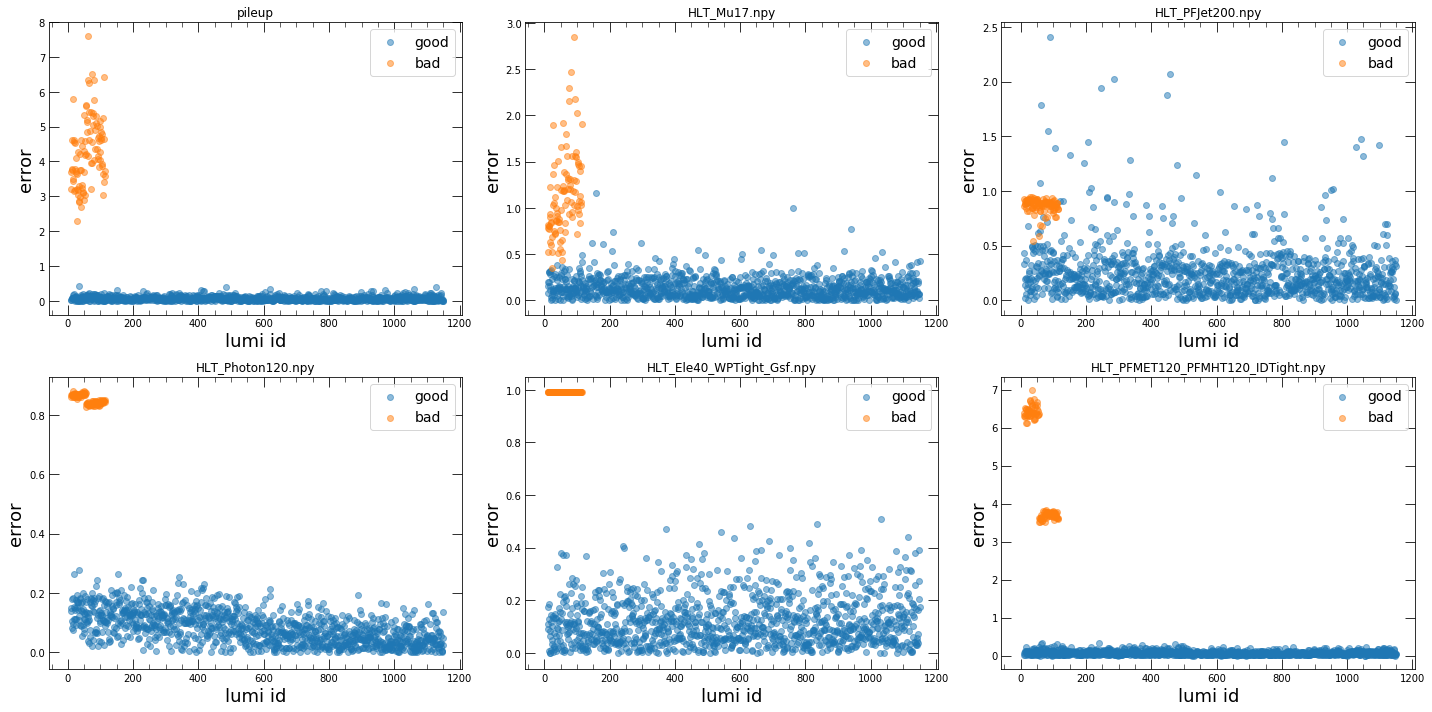

In [90]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

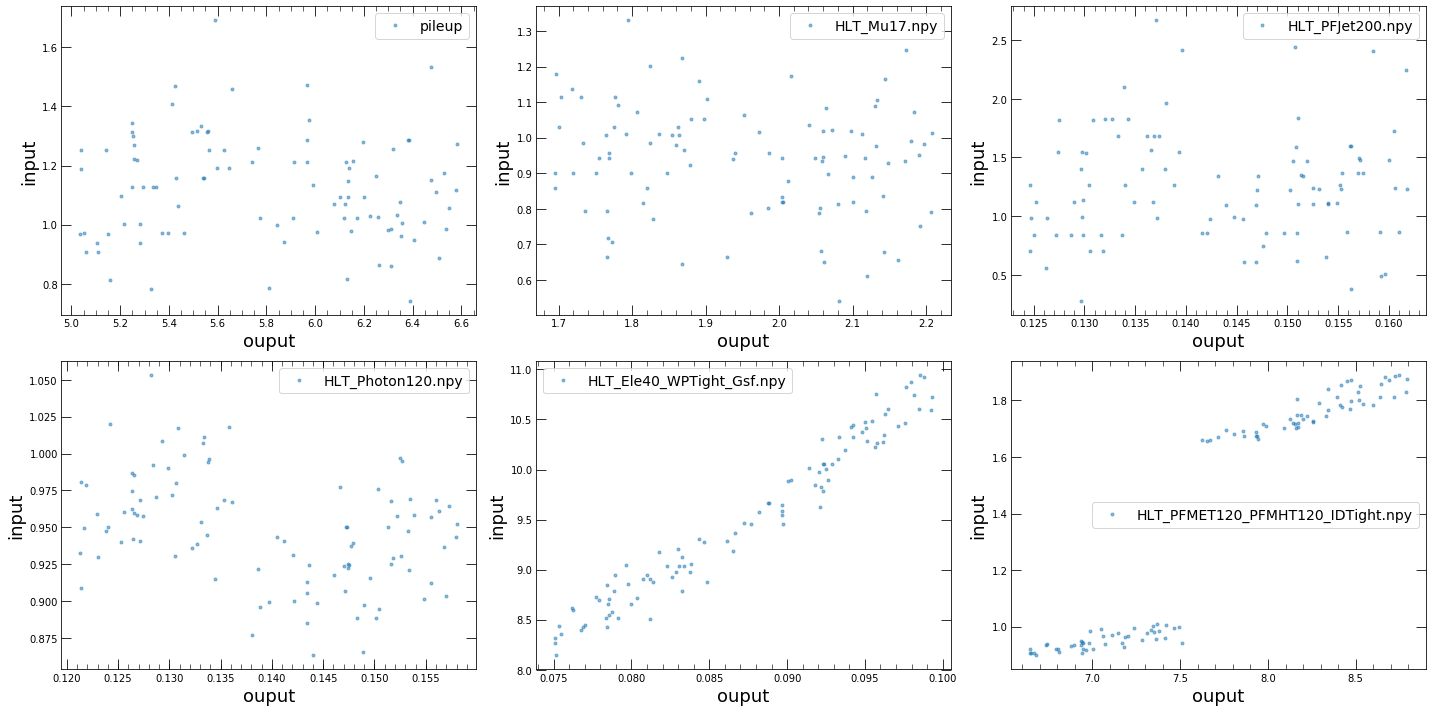

In [91]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()

## Squared Difference

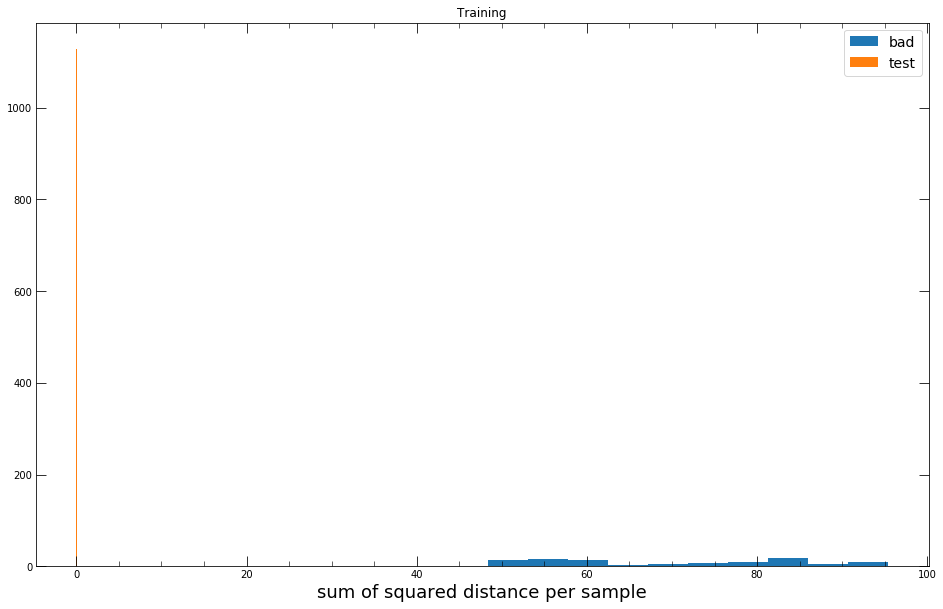

In [96]:
error_bad_real2 = []
for r in range(len(reconstructed_bad)):
    temp = 0
    for s in range(len(reconstructed_bad[r])):
        temp+=(reconstructed_bad[r][s]-x_train[r][s])**2
    error_bad_real2.append(temp)

plt.figure()
plt.hist(error_bad_real2,label='bad')
plt.hist(error_test,bins=1,label='test')
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.legend()
plt.show()